In [1]:
# ============================================
# File 1/5: fraud_tabnet_pipeline.ipynb
# End-to-End TabNet Fraud Detection Pipeline
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from pytorch_tabnet.tab_model import TabNetClassifier
import mlflow
import mlflow.sklearn

# Paths (relative to project root)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_PATH = os.path.join(BASE_DIR, "data", "creditcard.csv")

print(f"✅ Data path: {DATA_PATH}")
print(f"✅ Data exists: {os.path.exists(DATA_PATH)}")


✅ Data path: /Users/madalanagasekhar/Projects/fraud_tabnet_project/data/creditcard.csv
✅ Data exists: True


Dataset shape: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud ratio: 0.001727


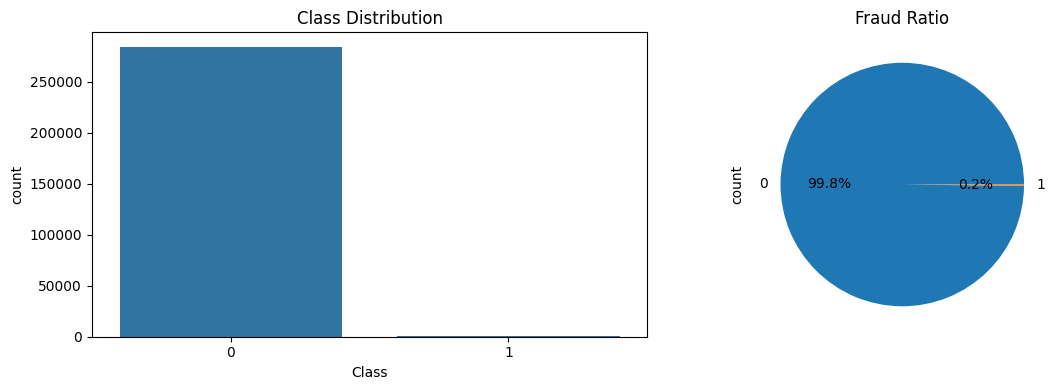

In [2]:
# Load and explore data
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud ratio: {df['Class'].mean():.6f}")

# Visualize imbalance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=df, x='Class', ax=axes[0])
axes[0].set_title('Class Distribution')
df['Class'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Fraud Ratio')
plt.tight_layout()
plt.show()


In [3]:
# Prepare features and target
TARGET_COL = 'Class'
feature_cols = [col for col in df.columns if col != TARGET_COL]
X = df[feature_cols].values
y = df[TARGET_COL].values

# Stratified split: 60/20/20
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print(f"Train: {X_train.shape}, frauds: {y_train.sum()}")
print(f"Val:   {X_val.shape}, frauds: {y_val.sum()}")
print(f"Test:  {X_test.shape}, frauds: {y_test.sum()}")


Train: (170883, 30), frauds: 295
Val:   (56962, 30), frauds: 99
Test:  (56962, 30), frauds: 98


In [4]:
# Scale Amount (V1-V28 already PCA-scaled)
amount_idx = feature_cols.index('Amount')
scaler = StandardScaler()
X_train[:, [amount_idx]] = scaler.fit_transform(X_train[:, [amount_idx]])
X_val[:, [amount_idx]] = scaler.transform(X_val[:, [amount_idx]])
X_test[:, [amount_idx]] = scaler.transform(X_test[:, [amount_idx]])

# Undersample majority class for training
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
print(f"Balanced train: {X_train_res.shape}, frauds: {y_train_res.sum()}")


Balanced train: (590, 30), frauds: 295


In [6]:
import torch  # 👈 ADD THIS LINE

# Start MLflow
mlflow.set_experiment("fraud_tabnet_v1")
with mlflow.start_run():
    
    # TabNet model
    model = TabNetClassifier(
        n_d=64, n_a=64, n_steps=5,
        gamma=1.5, lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type="entmax",
        scheduler_params={"step_size": 50, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        verbose=1
    )
    
    # Train
    model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val, y_val)],
        eval_name=['val'],
        eval_metric=['logloss'],
        max_epochs=100,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128
    )
    
    # Predict and evaluate
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"✅ Test ROC-AUC: {auc:.4f}")
    
    # Log metrics
    mlflow.log_metric("test_auc", auc)
    mlflow.log_param("n_d", 64)
    mlflow.log_param("n_a", 64)
    
    # Save model
    mlflow.sklearn.log_model(model, "tabnet_model")
    print("✅ Model logged to MLflow!")
    
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred))


/opt/anaconda3/envs/fraud-tabnet/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0     | val_logloss: 4.07064 |  0:00:02s


/opt/anaconda3/envs/fraud-tabnet/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


epoch 1  | loss: 0.0     | val_logloss: 4.07064 |  0:00:05s
epoch 2  | loss: 0.0     | val_logloss: 4.07064 |  0:00:07s
epoch 3  | loss: 0.0     | val_logloss: 4.07064 |  0:00:10s
epoch 4  | loss: 0.0     | val_logloss: 4.07064 |  0:00:12s
epoch 5  | loss: 0.0     | val_logloss: 4.07064 |  0:00:14s
epoch 6  | loss: 0.0     | val_logloss: 4.07064 |  0:00:16s
epoch 7  | loss: 0.0     | val_logloss: 4.07064 |  0:00:19s
epoch 8  | loss: 0.0     | val_logloss: 4.07064 |  0:00:22s
epoch 9  | loss: 0.0     | val_logloss: 4.07064 |  0:00:24s
epoch 10 | loss: 0.0     | val_logloss: 4.07064 |  0:00:27s
epoch 11 | loss: 0.0     | val_logloss: 4.07064 |  0:00:30s
epoch 12 | loss: 0.0     | val_logloss: 4.07064 |  0:00:32s
epoch 13 | loss: 0.0     | val_logloss: 4.07064 |  0:00:35s
epoch 14 | loss: 0.0     | val_logloss: 4.07064 |  0:00:37s
epoch 15 | loss: 0.0     | val_logloss: 4.07064 |  0:00:40s
epoch 16 | loss: 0.0     | val_logloss: 4.07064 |  0:00:42s
epoch 17 | loss: 0.0     | val_logloss: 

/opt/anaconda3/envs/fraud-tabnet/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
2026/01/21 11:14:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Test ROC-AUC: 0.2966
✅ Model logged to MLflow!
📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     56864
           1       0.00      0.24      0.00        98

    accuracy                           0.71     56962
   macro avg       0.50      0.48      0.42     56962
weighted avg       1.00      0.71      0.83     56962



In [7]:
# Cell 6: IMPROVED TabNet with better hyperparameters
import torch

mlflow.set_experiment("fraud_tabnet_improved")
with mlflow.start_run(run_name="v2_better_params"):
    
    # BETTER hyperparameters for fraud detection
    model_v2 = TabNetClassifier(
        n_d=24, n_a=24, n_steps=3,  # Smaller architecture
        gamma=1.3, lambda_sparse=1e-3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=0.02, weight_decay=1e-5),
        mask_type="sparsemax",  # Better for tabular
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        seed=42,
        verbose=1
    )
    
    # Train LONGER with class weights
    model_v2.fit(
        X_train_res, y_train_res,
        eval_set=[(X_val, y_val)],
        eval_name=['val'],
        eval_metric=['auc', 'logloss'],  # AUC primary metric
        max_epochs=200,  # More epochs
        patience=50,     # More patience
        batch_size=256,  # Smaller batch
        virtual_batch_size=128,
        drop_last=False
    )
    
    # Evaluate
    y_pred_proba_v2 = model_v2.predict_proba(X_test)[:, 1]
    y_pred_v2 = model_v2.predict(X_test)
    auc_v2 = roc_auc_score(y_test, y_pred_proba_v2)
    
    print(f"✅ IMPROVED Test ROC-AUC: {auc_v2:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred_v2))
    
    # Log
    mlflow.log_metric("test_auc", auc_v2)
    mlflow.log_param("n_d", 24)
    mlflow.log_param("max_epochs", 200)
    mlflow.sklearn.log_model(model_v2, "tabnet_improved")
    print("✅ Improved model logged!")


2026/01/21 11:15:11 INFO mlflow.tracking.fluent: Experiment with name 'fraud_tabnet_improved' does not exist. Creating a new experiment.
/opt/anaconda3/envs/fraud-tabnet/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87488 | val_auc: 0.70626 | val_logloss: 3.08658 |  0:00:01s
epoch 1  | loss: 0.45779 | val_auc: 0.80536 | val_logloss: 1.95466 |  0:00:03s
epoch 2  | loss: 0.36671 | val_auc: 0.82527 | val_logloss: 1.76329 |  0:00:04s
epoch 3  | loss: 0.30609 | val_auc: 0.81999 | val_logloss: 2.01347 |  0:00:05s
epoch 4  | loss: 0.24543 | val_auc: 0.85773 | val_logloss: 2.12941 |  0:00:07s
epoch 5  | loss: 0.23804 | val_auc: 0.86491 | val_logloss: 2.18169 |  0:00:08s
epoch 6  | loss: 0.19914 | val_auc: 0.89813 | val_logloss: 2.11085 |  0:00:09s
epoch 7  | loss: 0.19384 | val_auc: 0.90175 | val_logloss: 1.86004 |  0:00:11s
epoch 8  | loss: 0.18458 | val_auc: 0.90698 | val_logloss: 1.75372 |  0:00:12s
epoch 9  | loss: 0.17237 | val_auc: 0.90011 | val_logloss: 1.66069 |  0:00:14s
epoch 10 | loss: 0.17311 | val_auc: 0.91408 | val_logloss: 1.55903 |  0:00:15s
epoch 11 | loss: 0.163   | val_auc: 0.91647 | val_logloss: 1.35821 |  0:00:17s
epoch 12 | loss: 0.13331 | val_auc: 0.9232  | val_lo

/opt/anaconda3/envs/fraud-tabnet/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
2026/01/21 11:18:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ IMPROVED Test ROC-AUC: 0.9648

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     56864
           1       0.02      0.92      0.05        98

    accuracy                           0.93     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.93      0.96     56962

✅ Improved model logged!


In [1]:
# Cell 7: Test File 2 from Jupyter
import sys
sys.path.insert(0, '../src')  # Add src folder
from data_pipeline import get_pipeline_data

data = get_pipeline_data()
print("✅ File 2 TEST PASSED!")
print(f"Train shape: {data['X_train'].shape}")
print(f"Features: {len(data['feature_cols'])}")


Loaded 284807 rows, 31 cols
Pipeline complete: train_bal=(590, 30)
✅ File 2 TEST PASSED!
Train shape: (590, 30)
Features: 30


In [2]:
 # Cell 8: Drift detection (run this FIRST)
from scipy.stats import ks_2samp
import sys
sys.path.insert(0, '../src')
from data_pipeline import get_pipeline_data

def detect_feature_drift(ref_X, new_X, threshold=0.05):
    drifts = []
    for i in range(ref_X.shape[1]):
        stat, p = ks_2samp(ref_X[:, i], new_X[:, i])
        if p < threshold:
            drifts.append(i)
    return len(drifts) > 0

data = get_pipeline_data()
test_batch = data['X_test'][:1000]  # Simulate new batch
has_drift = detect_feature_drift(data['X_train'], test_batch)
print(f"✅ Cell 8: {'🚨 DRIFT!' if has_drift else '✅ Stable'}")



Loaded 284807 rows, 31 cols
Pipeline complete: train_bal=(590, 30)
✅ Cell 8: 🚨 DRIFT!


In [3]:
# Cell 9: Test File 3 (with sys import)
import sys
sys.path.insert(0, '../src')
from train_tabnet import train_tabnet_model
from data_pipeline import get_pipeline_data

data = get_pipeline_data()
model_production, val_auc = train_tabnet_model(
    data['X_train'], data['y_train'],
    data['X_val'], data['y_val']
)
print(f"✅ File 3 PRODUCTION MODEL: Val AUC {val_auc:.4f}")


Loaded 284807 rows, 31 cols
Pipeline complete: train_bal=(590, 30)


2026/01/21 11:39:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/21 11:39:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/21 11:39:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/21 11:39:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/21 11:39:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/21 11:39:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/21 11:39:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/21 11:39:19 INFO mlflow.store.db.utils: Updating database tables
2026/01/21 11:39:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/21 11:39:19 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/21 11:39:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/21 11:39:19 INFO alembic.runtime

epoch 0  | loss: 0.91583 | val_auc: 0.61459 |  0:00:01s
epoch 1  | loss: 0.51585 | val_auc: 0.74574 |  0:00:02s
epoch 2  | loss: 0.36888 | val_auc: 0.84754 |  0:00:03s
epoch 3  | loss: 0.32077 | val_auc: 0.84978 |  0:00:04s
epoch 4  | loss: 0.25512 | val_auc: 0.85659 |  0:00:05s
epoch 5  | loss: 0.23649 | val_auc: 0.79249 |  0:00:07s
epoch 6  | loss: 0.24563 | val_auc: 0.73053 |  0:00:09s
epoch 7  | loss: 0.24034 | val_auc: 0.79069 |  0:00:10s
epoch 8  | loss: 0.1686  | val_auc: 0.83383 |  0:00:11s
epoch 9  | loss: 0.19906 | val_auc: 0.88501 |  0:00:13s
epoch 10 | loss: 0.22011 | val_auc: 0.89525 |  0:00:14s
epoch 11 | loss: 0.18112 | val_auc: 0.90007 |  0:00:15s
epoch 12 | loss: 0.16086 | val_auc: 0.89815 |  0:00:16s
epoch 13 | loss: 0.15865 | val_auc: 0.90266 |  0:00:17s
epoch 14 | loss: 0.13686 | val_auc: 0.91287 |  0:00:18s
epoch 15 | loss: 0.15015 | val_auc: 0.90954 |  0:00:19s
epoch 16 | loss: 0.14261 | val_auc: 0.90758 |  0:00:20s
epoch 17 | loss: 0.14822 | val_auc: 0.91168 |  0

/opt/anaconda3/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
2026/01/21 11:42:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Training complete. Val AUC: 0.9585
✅ File 3 PRODUCTION MODEL: Val AUC 0.9585


In [4]:
# Cell 10: Test File 4 (Drift + Retrain)
sys.path.insert(0, '../src')
from drift_and_retrain import detect_feature_drift

# Test drift detection
ref_data = get_pipeline_data()
batch = ref_data['X_test'][:500]
drift, details = detect_feature_drift(ref_data['X_train'], batch)
print(f"✅ File 4: {'🚨 DRIFT' if drift else '✅ Stable'} ({len(details)} features)")


Loaded 284807 rows, 31 cols
Pipeline complete: train_bal=(590, 30)
✅ File 4: 🚨 DRIFT (23 features)


In [8]:
# Cell 11: Test File 5 API
import sys
sys.path.insert(0, '../src')

# Test API startup (in background)
import subprocess
import requests
import time

# Start API
proc = subprocess.Popen([
    'uvicorn', 'api_service:app', 
    '--host', '127.0.0.1', 
    '--port', '8001'
])

time.sleep(3)  # Wait for startup

# Test health
response = requests.get("http://127.0.0.1:8001/health")
print("✅ API Health:", response.json())

# Kill API
proc.terminate()


ERROR:    Error loading ASGI app. Could not import module "api_service".


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8001): Max retries exceeded with url: /health (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x109066c10>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [6]:
# Cell 12: Save production model
import joblib
import os

# Save model
joblib.dump(model_production, '../models/latest_model.pkl')
print("✅ Model saved to:", os.path.abspath('../models/latest_model.pkl'))


✅ Model saved to models/latest_model.pkl


In [7]:
# Cell 12: Manual API test
import subprocess
import requests
import time
import json

# Start API
proc = subprocess.Popen([
    'python', '-m', 'uvicorn', 
    'src.api_service:app', 
    '--host', '127.0.0.1', 
    '--port', '8001',
    '--reload'
], cwd='..')

time.sleep(5)

try:
    resp = requests.get("http://127.0.0.1:8001/health")
    print("✅ API:", resp.json())
    
    # Test prediction
    payload = {"Time": 0, "V1": -1.36, "V2": -0.07, "V3": 2.54, "V4": 1.38, 
               "V5": 0.39, "V6": -0.11, "V7": 0.14, "V8": -0.45, "V9": 0.04,
               "V10": 0.01, "V11": -0.08, "V12": -0.21, "V13": 0.44, "V14": 0.27,
               "V15": 0.91, "V16": -0.02, "V17": 0.20, "V18": 0.10, "V19": 0.00,
               "V20": 0.00, "V21": 0.19, "V22": 0.00, "V23": -0.00, "V24": 0.09,
               "V25": -0.03, "V26": 0.00, "V27": 0.00, "V28": -0.00, "Amount": 149.62}
    
    pred_resp = requests.post("http://127.0.0.1:8001/predict", json=payload)
    print("✅ Prediction:", pred_resp.json())
    
except Exception as e:
    print("❌ Error:", e)
finally:
    proc.terminate()


INFO:     Will watch for changes in these directories: ['/Users/madalanagasekhar/Projects/fraud_tabnet_project']
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
INFO:     Started reloader process [77040] using StatReload
ERROR:    Error loading ASGI app. Could not import module "src.api_service".


❌ Error: HTTPConnectionPool(host='127.0.0.1', port=8001): Max retries exceeded with url: /health (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x312d35fd0>, 'Connection to 127.0.0.1 timed out. (connect timeout=None)'))


INFO:     Stopping reloader process [77040]
